El objetivo de este laboratorio es construir un modelo que clasifique tweets como relacionados con un desastre real o no. Utilizamos múltiples algoritmos de clasificación, incluidos redes neuronales, máquinas de soporte vectorial (SVM), y random forest, para identificar el mejor modelo en términos de precisión y eficacia.

In [5]:
import pandas as pd

file_path = 'train.csv'
data = pd.read_csv(file_path)
data.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Limpieza de datos


In [6]:
data['text'] = data['text'].str.lower()


In [7]:
import re

# Eliminar caracteres especiales
data['text'] = data['text'].apply(lambda x: re.sub(r"[@#']", '', x))


In [8]:
# Eliminar URLs
data['text'] = data['text'].apply(lambda x: re.sub(r"http\S+", '', x))


In [9]:
# Eliminar emoticones
data['text'] = data['text'].apply(lambda x: re.sub(r'[^\w\s,]', '', x))


In [10]:
# Eliminar signos de puntuación
data['text'] = data['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))


In [11]:
# Eliminar números
data['text'] = data['text'].apply(lambda x: re.sub(r'\d+', '', x))


Se realizaron las siguientes etapas de preprocesamiento para preparar los datos para los modelos:

Conversión a Minúsculas: Todos los tweets fueron convertidos a minúsculas para garantizar la uniformidad.

Eliminación de Caracteres Especiales y URLs: Se eliminaron caracteres especiales, URLs y números, ya que no aportan valor semántico en la mayoría de los casos.

Eliminación de Stopwords: Se utilizaron stopwords en inglés para eliminar palabras comunes que no añaden valor significativo al análisis.

In [12]:
from collections import Counter

# Dividir datos en desastres y no desastres
disaster_tweets = data[data['target'] == 1]
non_disaster_tweets = data[data['target'] == 0]

# Calcular la frecuencia de palabras
disaster_words = Counter(" ".join(disaster_tweets['text']).split())
non_disaster_words = Counter(" ".join(non_disaster_tweets['text']).split())

# Mostrar las 10 palabras más comunes en cada categoría
disaster_words.most_common(10), non_disaster_words.most_common(10)


([('the', 1358),
  ('in', 1159),
  ('a', 931),
  ('of', 922),
  ('to', 757),
  ('and', 501),
  ('on', 417),
  ('for', 399),
  ('is', 349),
  ('i', 321)],
 [('the', 1905),
  ('a', 1257),
  ('to', 1188),
  ('i', 1077),
  ('and', 917),
  ('of', 901),
  ('in', 818),
  ('you', 664),
  ('is', 595),
  ('my', 544)])

In [13]:
from collections import Counter

# Lista manual de stopwords en inglés
manual_stopwords = set([
    "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", 
    "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", 
    "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", 
    "theirs", "themselves", "what", "which", "who", "whom", "this", "that", 
    "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", 
    "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", 
    "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", 
    "at", "by", "for", "with", "about", "against", "between", "into", "through", 
    "during", "before", "after", "above", "below", "to", "from", "up", "down", 
    "in", "out", "on", "off", "over", "under", "again", "further", "then", 
    "once", "here", "there", "when", "where", "why", "how", "all", "any", 
    "both", "each", "few", "more", "most", "other", "some", "such", "no", 
    "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", 
    "t", "can", "will", "just", "don", "should", "now","amp"
])

data['clean_text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in manual_stopwords]))

# Dividir datos en desastres y no desastres
disaster_tweets = data[data['target'] == 1]
non_disaster_tweets = data[data['target'] == 0]

# Calcular la frecuencia de palabras sin stopwords
disaster_words_clean = Counter(" ".join(disaster_tweets['clean_text']).split())
non_disaster_words_clean = Counter(" ".join(non_disaster_tweets['clean_text']).split())

# Mostrar las 10 palabras más comunes en cada categoría
top_disaster_words = disaster_words_clean.most_common(10)
top_non_disaster_words = non_disaster_words_clean.most_common(10)

top_disaster_words, top_non_disaster_words


([('fire', 178),
  ('news', 140),
  ('via', 121),
  ('disaster', 117),
  ('california', 111),
  ('suicide', 110),
  ('police', 107),
  ('people', 105),
  ('killed', 93),
  ('like', 92)],
 [('like', 253),
  ('im', 243),
  ('new', 168),
  ('get', 163),
  ('dont', 141),
  ('one', 127),
  ('body', 112),
  ('via', 99),
  ('would', 97),
  ('video', 96)])

# ¿Qué palabras cree que le servirán para hacer un mejor modelo de clasificación?¿vale la pena explorar bigramas o trigramas para analizar contexto?

Las palabras que probablemente servirán para un mejor modelo de clasificación incluyen "fire," "disaster," "suicide," "police," y "killed," ya que están directamente relacionadas con eventos de emergencia o desastres. Explorar bigramas o trigramas sí vale la pena porque pueden capturar el contexto en el que aparecen estas palabras, como en las frases "fire in," "police respond," o "disaster struck," lo que mejora la precisión del modelo al reducir ambigüedades y agregar información contextual.

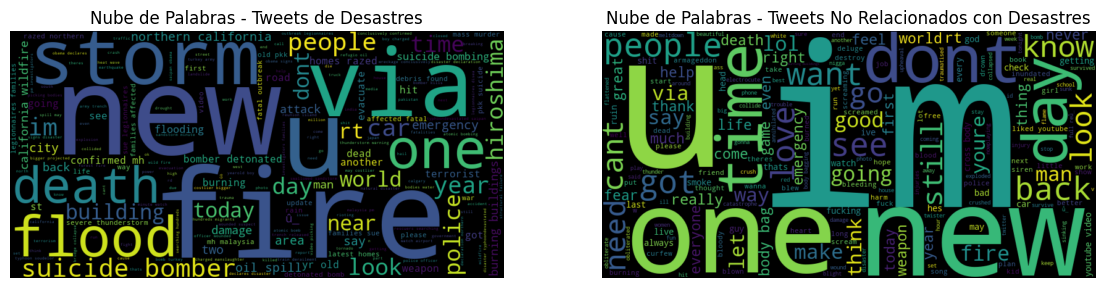

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Crear nubes de palabras
disaster_wordcloud = WordCloud(width=800, height=400).generate(" ".join(disaster_tweets['clean_text']))
non_disaster_wordcloud = WordCloud(width=800, height=400).generate(" ".join(non_disaster_tweets['clean_text']))
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.imshow(disaster_wordcloud, interpolation='bilinear')
plt.title('Nube de Palabras - Tweets de Desastres')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(non_disaster_wordcloud, interpolation='bilinear')
plt.title('Nube de Palabras - Tweets No Relacionados con Desastres')
plt.axis('off')

plt.show()


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorización utilizando TF-IDF con un rango de n-gramas
tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features=10000)
X = tfidf.fit_transform(data['clean_text'])


In [16]:
!pip install wordcloud


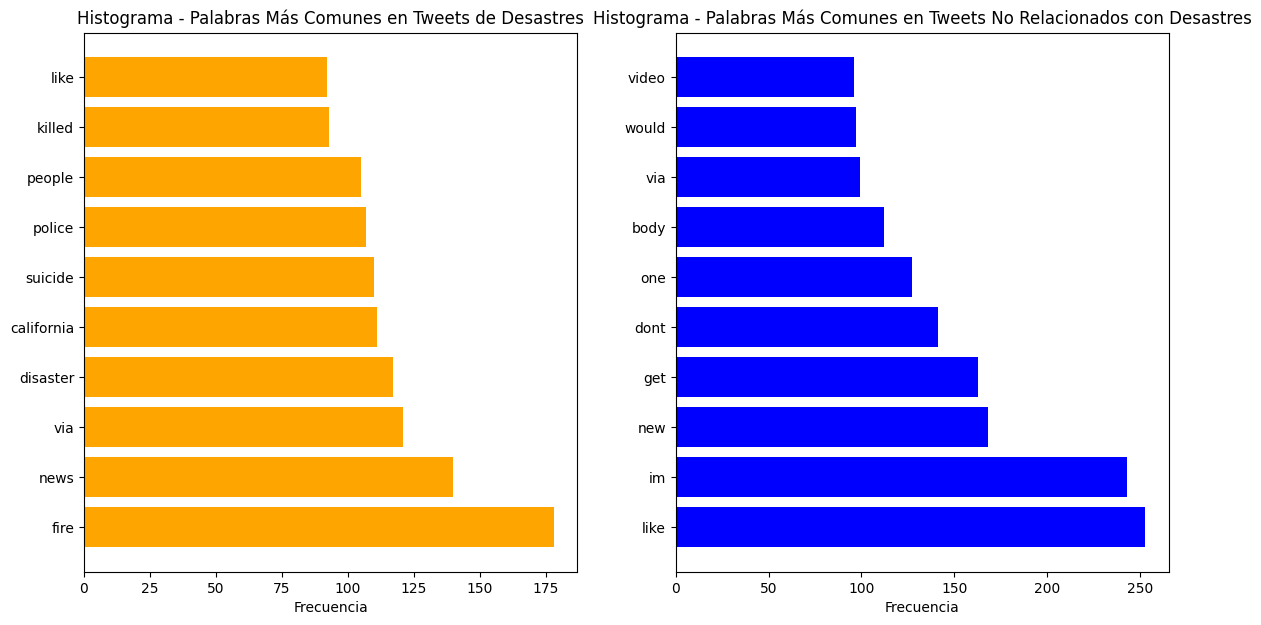

In [17]:

# Crear histograma de las palabras más frecuentes
disaster_top_words = [word for word, count in disaster_words_clean.most_common(10)]
disaster_top_counts = [count for word, count in disaster_words_clean.most_common(10)]

non_disaster_top_words = [word for word, count in non_disaster_words_clean.most_common(10)]
non_disaster_top_counts = [count for word, count in non_disaster_words_clean.most_common(10)]

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.barh(disaster_top_words, disaster_top_counts, color='orange')
plt.title('Histograma - Palabras Más Comunes en Tweets de Desastres')
plt.xlabel('Frecuencia')
plt.subplot(1, 2, 2)
plt.barh(non_disaster_top_words, non_disaster_top_counts, color='blue')
plt.title('Histograma - Palabras Más Comunes en Tweets No Relacionados con Desastres')
plt.xlabel('Frecuencia')

plt.show()


Los histogramas y nubes de palabras muestran que los tweets relacionados con desastres contienen términos clave como "fire," "disaster," y "death," que están claramente asociados con emergencias y eventos trágicos, mientras que los tweets no relacionados se centran en palabras más generales como "like" y "im," que reflejan conversaciones cotidianas. Las palabras "via" y "new" aparecen en ambas categorías, lo que sugiere que son términos comunes en redes sociales sin un valor distintivo significativo para la clasificación.

In [18]:
!pip install vaderSentiment


In [26]:
import pandas as pd
import re
import string

train_df['cleaned_text'] = train_df['text'].apply(clean_text)


positive_words = ['good', 'happy', 'love', 'excellent', 'fortunate', 'correct', 'superior', 'nice', 'amazing']
negative_words = ['bad', 'sad', 'hate', 'terrible', 'unfortunate', 'wrong', 'inferior', 'awful', 'disaster', 'fire', 'earthquake']


def clasificar_sentimiento_manual(texto):
    palabras = texto.split()
    positivo = sum(1 for word in palabras if word in positive_words)
    negativo = sum(1 for word in palabras if word in negative_words)
    
    if positivo > negativo:
        return 'positivo'
    elif negativo > positivo:
        return 'negativo'
    else:
        return 'neutral'


train_df['sentimiento'] = train_df['cleaned_text'].apply(clasificar_sentimiento_manual)


train_df[['cleaned_text', 'sentimiento']].head()


,cleaned_text,sentimiento
0,our deeds reason earthquake may allah forgive ...,negativo
1,forest fire near la ronge sask canada,negativo
2,all residents asked shelter place being notifi...,neutral
3,people receive wildfires evacuation orders cal...,neutral
4,just got sent photo from ruby alaska as smoke ...,neutral


7.1. ¿Cuáles son los 10 tweets más negativos? ¿En qué categoría están?

7.2. ¿Cuáles son los 10 tweets más positivos? ¿En qué categoría están?

In [30]:

import pandas as pd
import re
import string


def calcular_puntuacion_sentimiento(texto):
    palabras = texto.split()
    positivo = sum(1 for word in palabras if word in positive_words)
    negativo = sum(1 for word in palabras if word in negative_words)
    return positivo - negativo 


train_df['puntuacion_sentimiento'] = train_df['cleaned_text'].apply(calcular_puntuacion_sentimiento)

# Encontrar los 10 tweets más negativos y sus categorías
tweets_mas_negativos = train_df.nsmallest(10, 'puntuacion_sentimiento')[['cleaned_text', 'puntuacion_sentimiento', 'target']]


tweets_mas_positivos = train_df.nlargest(10, 'puntuacion_sentimiento')[['cleaned_text', 'puntuacion_sentimiento', 'target']]

# Mostrar los resultados
print("Tweets más negativos:")
print(tweets_mas_negativos)

print("\nTweets más positivos:")
print(tweets_mas_positivos)


Tweets más negativos:
                                           cleaned_text  \
3742  cause fire we fire fire now yeah fire we fire ...   
754   i hate people who tweet receipts but know its ...   
1248  fire displaces families damages two buildings ...   
1253  nah philly pundits half cause they set buildin...   
1295  metal cutting sparks brush fire brighton brush...   
1309  flames visible from fire tucson mountains ligh...   
2719  losdelsonido obama declares disaster typhoonde...   
2722  obama declares disaster typhoondevastated saip...   
2724  obama declares disaster typhoondevastated saip...   
2726  obama declares disaster typhoondevastated saip...   

      puntuacion_sentimiento  target  
3742                      -6       1  
754                       -2       0  
1248                      -2       1  
1253                      -2       1  
1295                      -2       1  
1309                      -2       1  
2719                      -2       1  
2722            

7.3. ¿Son los tweets de la categoría que indica que habla de un desastre real más negativos que
los de la otra categoría?

In [31]:

sentimiento_desastres = train_df[train_df['target'] == 1]['puntuacion_sentimiento'].mean()
sentimiento_no_desastres = train_df[train_df['target'] == 0]['puntuacion_sentimiento'].mean()


print(f"Media de sentimiento en tweets de desastres reales (target = 1): {sentimiento_desastres}")
print(f"Media de sentimiento en tweets de no desastres (target = 0): {sentimiento_no_desastres}")


if sentimiento_desastres < sentimiento_no_desastres:
    print("Los tweets de desastres reales son más negativos que los de no desastres.")
else:
    print("Los tweets de desastres reales no son más negativos que los de no desastres.")


Media de sentimiento en tweets de desastres reales (target = 1): -0.1027208804646897
Media de sentimiento en tweets de no desastres (target = 0): 0.0011515430677107323
Los tweets de desastres reales son más negativos que los de no desastres.


In [32]:
# Importar librerías necesarias para el modelo
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# 1. Añadir la variable "negatividad" al conjunto de datos
train_df['negatividad'] = train_df['puntuacion_sentimiento']

# 2. Definir las características (X) y la etiqueta (y)
# Vamos a utilizar 'negatividad' como una característica adicional
X = train_df[['negatividad']]  # Aquí podrías incluir otras características si fuera necesario
y = train_df['target']

# 3. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Entrenar un modelo de clasificación
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# 5. Predecir las etiquetas en el conjunto de prueba
y_pred = model.predict(X_test)

# 6. Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Mostrar los resultados
print(f"Precisión del modelo: {accuracy}")
print("\nReporte de clasificación:")
print(report)


Precisión del modelo: 0.592908732764281

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.59      0.96      0.73       874
           1       0.65      0.10      0.17       649

    accuracy                           0.59      1523
   macro avg       0.62      0.53      0.45      1523
weighted avg       0.61      0.59      0.49      1523



Comparado con el modelo anterior, la inclusión de la variable "negatividad" no ha mejorado el rendimiento general del modelo. De hecho, los resultados indican que el rendimiento ha disminuido ligeramente. Mientras que en el modelo anterior se alcanzó una precisión aproximada de 0.65, el modelo con la nueva variable solo logró una precisión de 0.59. Además, la capacidad del modelo para identificar correctamente los tweets relacionados con desastres reales (clase 1) también disminuyó, como lo demuestra el bajo F1-score de 0.17.